In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from ACAgraphML.Plotting import plotGraph

%load_ext autoreload
%autoreload 2

In [7]:
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import SteadyStateTransform
dataset = ZINC_Dataset.SMALL_TRAIN.load()
steadyDataset = SteadyStateTransform()(dataset)

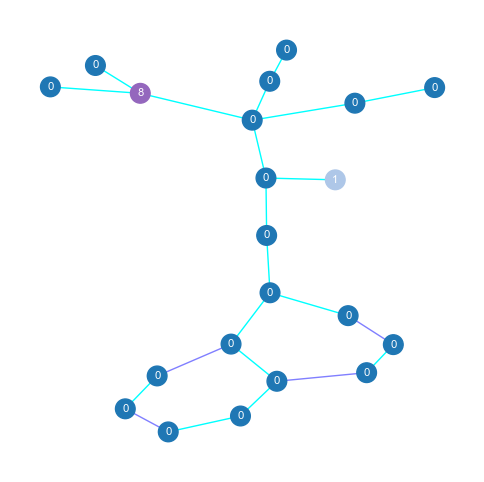

In [3]:
graph = dataset[4]
plotGraph(graph)

In [5]:
dataset.edge_index[:, :100]

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  5,  5,  5,  6,  6,  7,  7,  8,
          8,  8,  9, 10, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 15, 15, 15,
         16, 16, 16, 16, 17, 18, 19, 19, 19, 20, 20, 21, 21, 21, 22, 23, 23, 24,
         24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 29, 30, 30, 30, 31, 32, 32, 32,
         33, 33, 34, 34, 35, 35, 36, 36, 36, 37, 38, 38, 38, 39, 39, 40, 40, 41,
         41, 41, 42, 42, 42, 43, 44, 44, 44, 45],
        [ 1,  0,  2,  1,  3, 28,  2,  4,  3,  5,  4,  6, 27,  5,  7,  6,  8,  7,
          9, 10,  8,  8, 11, 27, 10, 12, 11, 13, 26, 12, 14, 13, 15, 14, 16, 25,
         15, 17, 18, 19, 16, 16, 16, 20, 24, 19, 21, 20, 22, 23, 21, 21, 24, 19,
         23, 15, 26, 12, 25,  5, 10, 28,  2, 27, 30, 29, 31, 32, 30, 30, 33, 52,
         32, 34, 33, 35, 34, 36, 35, 37, 38, 36, 36, 39, 51, 38, 40, 39, 41, 40,
         42, 50, 41, 43, 44, 42, 42, 45, 49, 44]])

Min steady state: 0.0, Max steady state: 0.18182030320167542


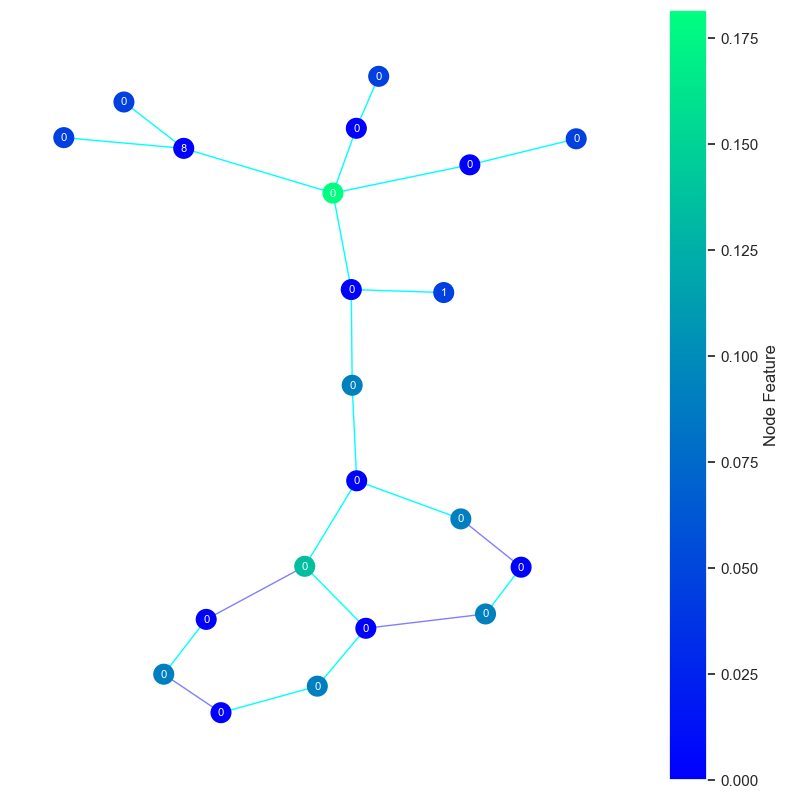

In [6]:
from torch_geometric.utils import to_dense_adj
adj = to_dense_adj(graph.edge_index, batch=graph.batch, max_num_nodes=graph.num_nodes)

#make it a transition probability matrix
adj = adj / adj.sum(dim=-1, keepdim=True)
steadyState = torch.linalg.matrix_power(adj[0], 1000)[0]

print(f'Min steady state: {steadyState.min()}, Max steady state: {steadyState.max()}')

fig, ax = plt.subplots(figsize=(10, 10))
plotGraph(graph,
          getNodeColors=lambda x: steadyState.cpu().numpy(),
          minNodeFeat=None,
          maxNodeFeat=None,
          nodesCmap='winter',
          ax=ax,
          colorBar=True)

In [102]:
steadyState

tensor([0.0455, 0.0000, 0.1818, 0.0000, 0.0455, 0.0000, 0.0455, 0.0909, 0.0000,
        0.0909, 0.0000, 0.0909, 0.0000, 0.0909, 0.0000, 0.0909, 0.0000, 0.1364,
        0.0000, 0.0455, 0.0455])

In [103]:
feats = graph.x.squeeze()
uniques, counts = torch.unique(feats, return_counts=True)
counts / sum(counts)

tensor([0.9048, 0.0476, 0.0476])

In [104]:
steadyStateCounts = torch.zeros_like(uniques, dtype=torch.float)
for i, u in enumerate(uniques):
    steadyStateCounts[i] = steadyState[feats == u].sum()
steadyStateCounts

tensor([0.9546, 0.0455, 0.0000])

In [ ]:
from tqdm.notebook import tqdm

In [8]:
#Compute the steady state for all the graphs in the dataset
steadyStates = []
for graph in tqdm(dataset):
    adj = to_dense_adj(graph.edge_index, batch=graph.batch, max_num_nodes=graph.num_nodes)
    adj = adj / adj.sum(dim=-1, keepdim=True)
    steadyState = torch.linalg.matrix_power(adj[0], 1000)[0]
    steadyStates.append(steadyState)



NameError: name 'tqdm' is not defined

In [106]:
steadyStatesFeats = torch.zeros((len(dataset), 28), dtype=torch.float)

for i in range(len(dataset)):
    steadyState = steadyStates[i]
    feats = dataset[i].x.squeeze()
    uniques, counts = torch.unique(feats, return_counts=True)
    for j, u in enumerate(uniques):
        steadyStatesFeats[i, u] = steadyState[feats == u].sum()

In [107]:
steadyStatesFeats.shape

torch.Size([10000, 28])

# Node feat BOW

In [108]:
torch.max(dataset.x)

tensor(20)

In [109]:
from torch_geometric.utils import one_hot
#onehot at the node level
oneHot = one_hot(dataset.x.squeeze(), num_classes=torch.max(dataset.x).item() + 1)

In [110]:
node_counts = torch.Tensor([g.x.shape[0] for g in dataset])
nodeCountCumSum = node_counts.cumsum(dim=0).int()
nodeCountCumSum.shape

torch.Size([10000])

In [111]:
graphBON = torch.zeros((len(dataset), oneHot.shape[1]), dtype=torch.float)
for i in range(len(dataset)):
    graphBON[i] = oneHot[nodeCountCumSum[i]:nodeCountCumSum[i]+node_counts[i].int()].sum(dim=0)
graphBON.shape

torch.Size([10000, 21])

In [112]:
graphBON_target = torch.cat([graphBON, dataset.y.unsqueeze(1)], dim=1)
graphBON_target.shape

torch.Size([10000, 22])

In [113]:
import pandas as pd
df = pd.DataFrame(graphBON_target.cpu().numpy(), columns=[f'Node_{i}' for i in range(graphBON.shape[1])] + ['Target'])
df.head()


,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9,...,Node_12,Node_13,Node_14,Node_15,Node_16,Node_17,Node_18,Node_19,Node_20,Target
0,21.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.835036
1,21.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.193549
2,13.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.842230
3,21.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711533
4,12.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246347


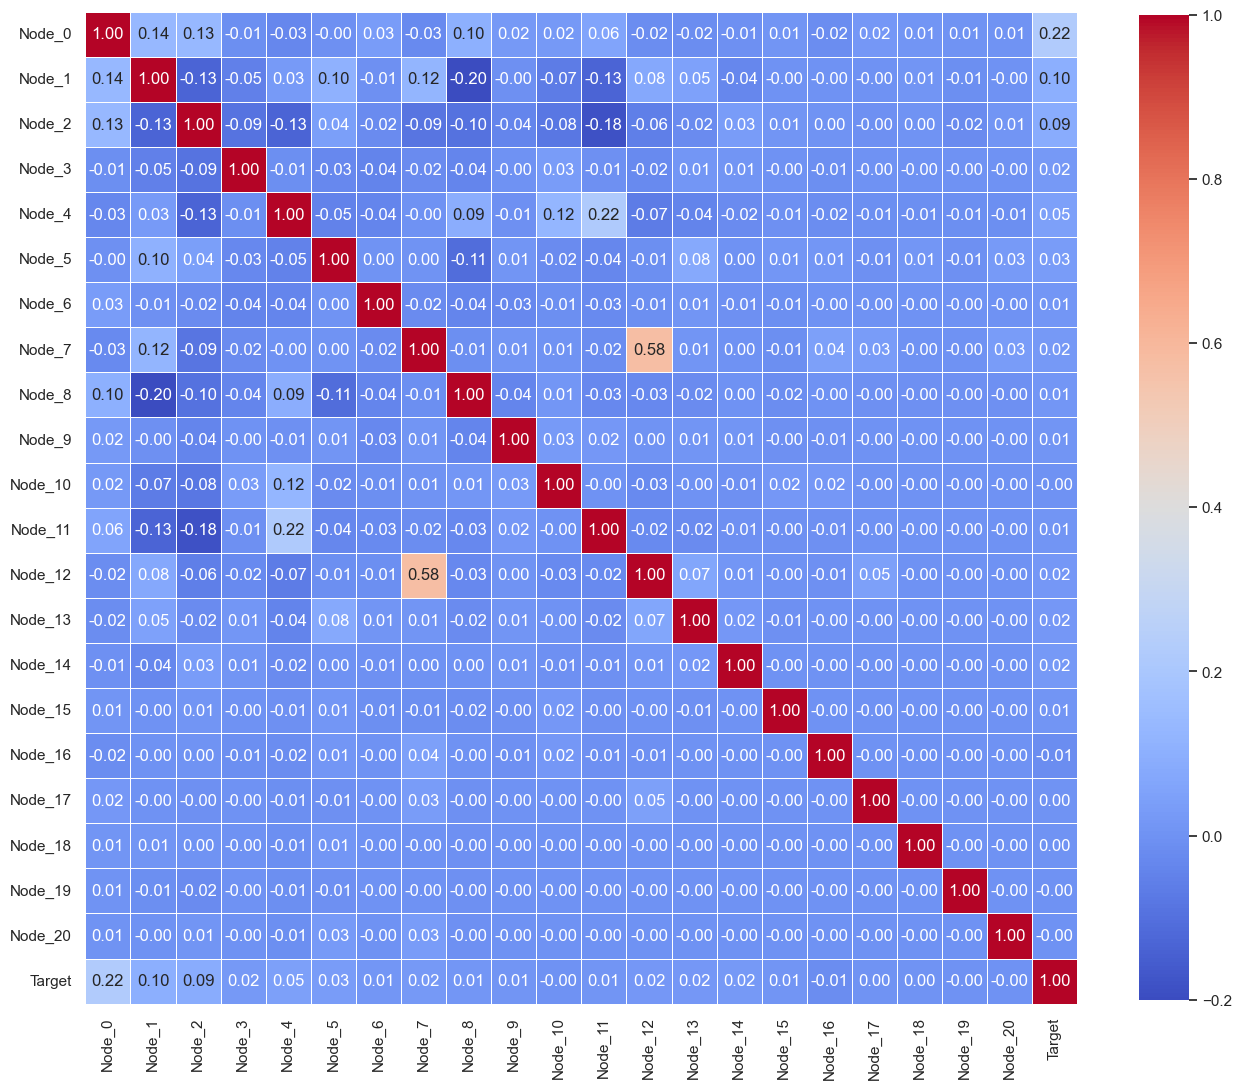

In [114]:
corr = df.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.show()

<Figure size 1000x600 with 0 Axes>

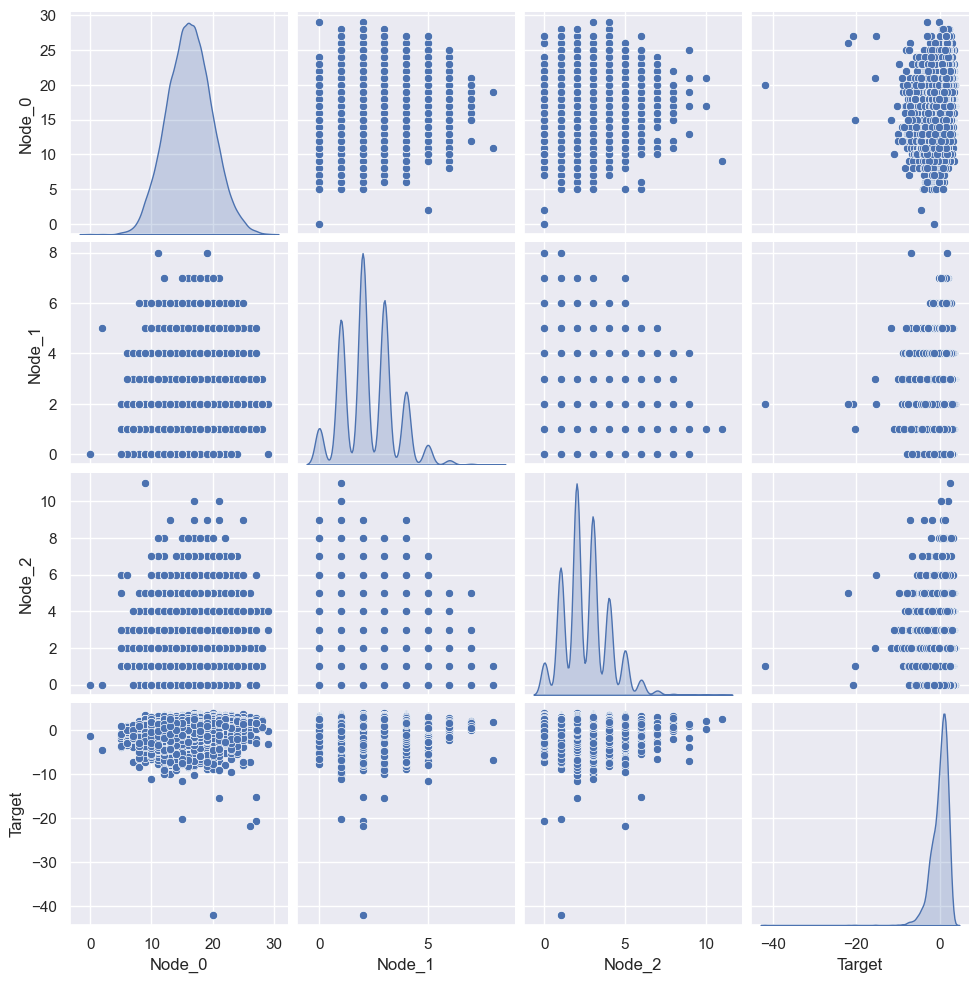

In [115]:
plt.figure(figsize=(10, 6))
sns.pairplot(df[['Node_0', 'Node_1', 'Node_2', 'Target']], diag_kind='kde', markers='o')
plt.show()

# Ridge Regression using BOW features

In [116]:
x = graphBON
t = graphBON_target[:, -1]  # Target is the last column

In [117]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(n_jobs=8)
model.fit(x, t)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,8
,positive,False


In [118]:
y = model.predict(x)
#Compute all the metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(t, y)
r2 = r2_score(t, y)
mae = mean_absolute_error(t, y)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 3.77291202545166
R^2 Score: 0.06689542531967163
Mean Absolute Error: 1.4302988052368164


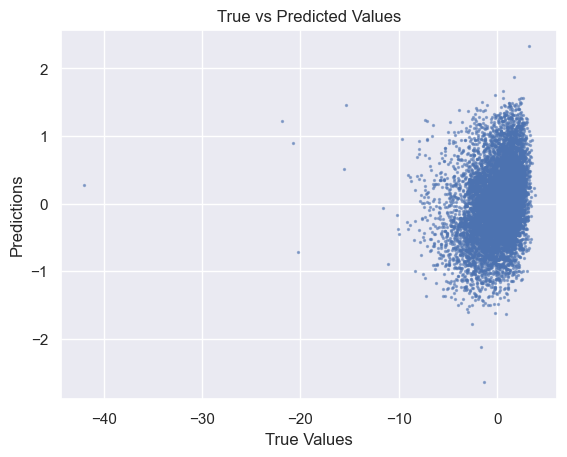

In [119]:
plt.scatter(t, y, alpha=0.5, marker='o', s=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

In [120]:
# Try Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=200, n_jobs=16, random_state=42)
rf_model.fit(x, t)
y_rf = rf_model.predict(x)
mse_rf = mean_squared_error(t, y_rf)
r2_rf = r2_score(t, y_rf)
mae_rf = mean_absolute_error(t, y_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')
print(f'Random Forest R^2 Score: {r2_rf}')
print(f'Random Forest Mean Absolute Error: {mae_rf}')

Random Forest Mean Squared Error: 1.449955745867432
Random Forest R^2 Score: 0.6414015624368143
Random Forest Mean Absolute Error: 0.8529893281439036


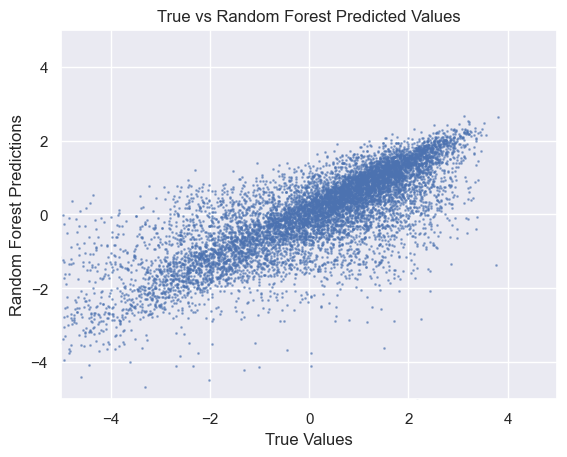

In [121]:
plt.scatter(t, y_rf, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Random Forest Predictions')
plt.title('True vs Random Forest Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# Random forset with steady state bon

In [122]:
df_steady = pd.DataFrame(steadyStatesFeats.cpu().numpy(), columns=[f'Node_{i}' for i in range(steadyStatesFeats.shape[1])])
df_steady['Target'] = dataset.y.cpu().numpy()
df_steady.head()

,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9,...,Node_19,Node_20,Node_21,Node_22,Node_23,Node_24,Node_25,Node_26,Node_27,Target
0,0.721566,0.076570,0.140312,0.0,0.0,0.061565,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.835036
1,0.732586,0.035779,0.177925,0.0,0.0,0.000000,0.000000,0.000000,0.053722,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.193549
2,0.794160,0.029408,0.147041,0.0,0.0,0.000000,0.029404,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.842230
3,0.733346,0.000000,0.183336,0.0,0.0,0.033334,0.000000,0.016667,0.033334,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.711533
4,0.954557,0.045455,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246347


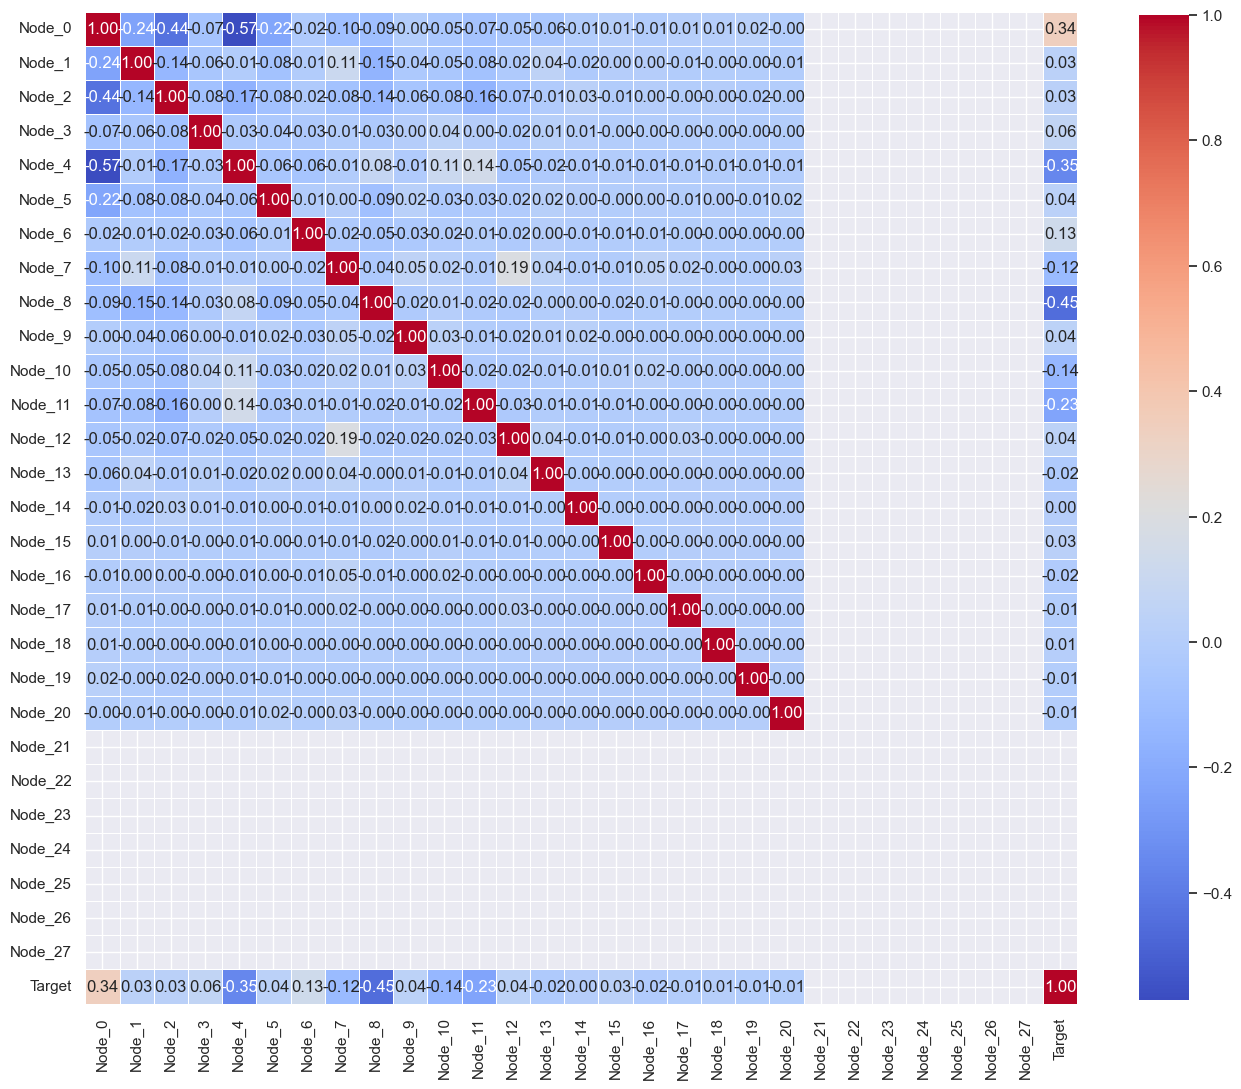

In [123]:
#print correlation matrix
corr_steady = df_steady.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_steady, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.show()

<Figure size 1000x600 with 0 Axes>

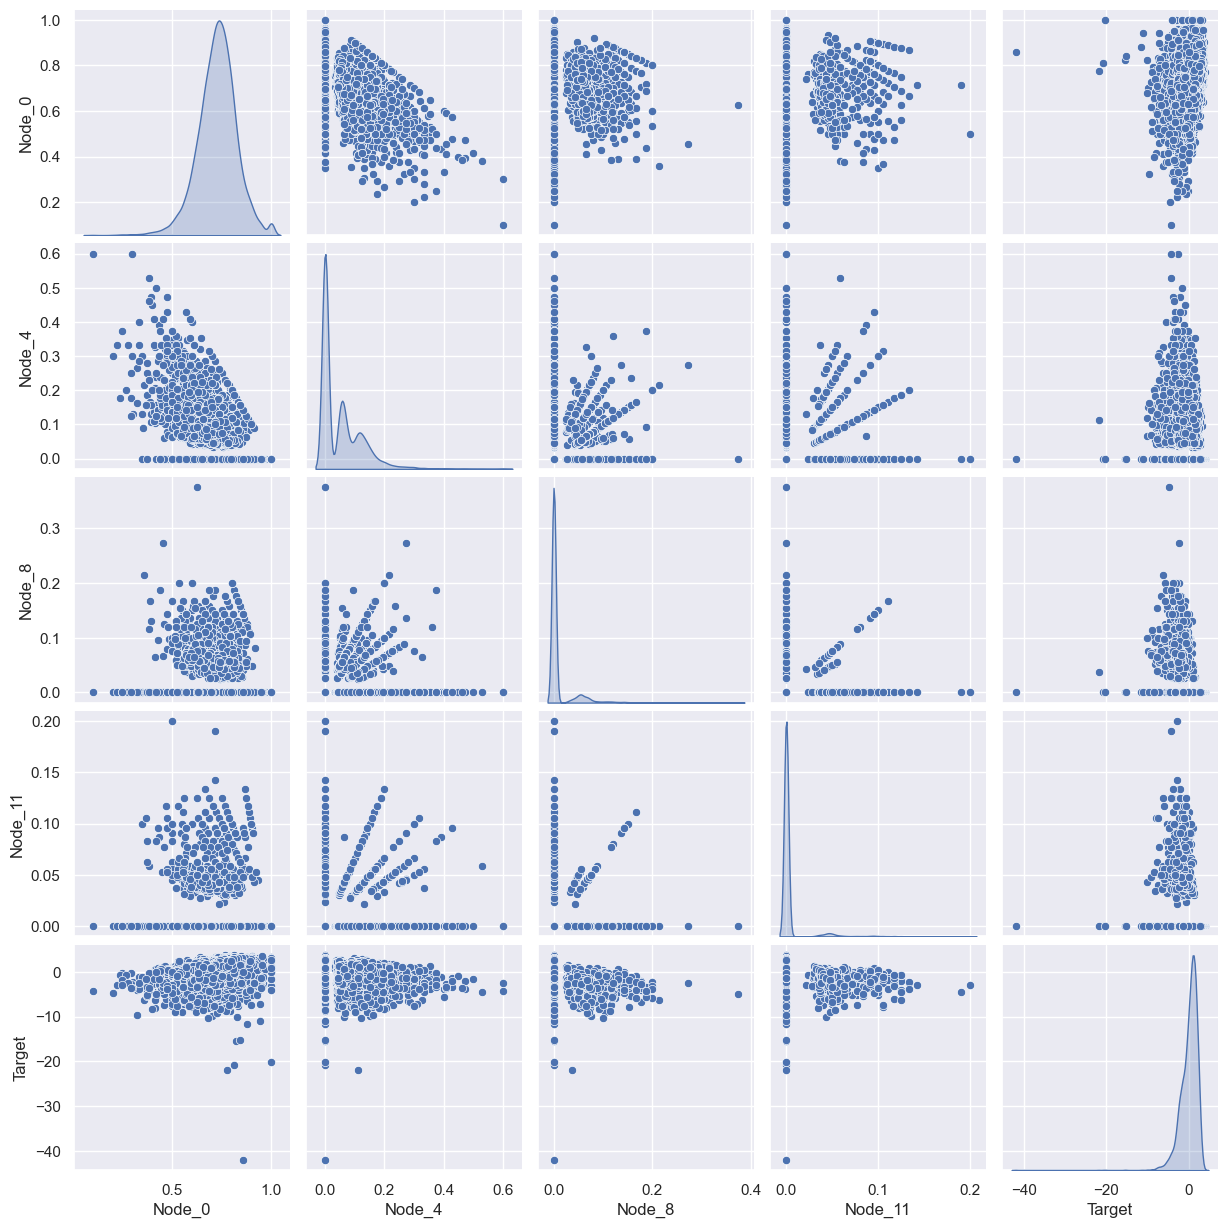

In [124]:
#pairplot
plt.figure(figsize=(10, 6))
sns.pairplot(df_steady[['Node_0', 'Node_4', 'Node_8', 'Node_11', 'Target']], diag_kind='kde', markers='o')
plt.show()

Steady State Random Forest Mean Squared Error: 0.3655317901781622
Steady State Random Forest R^2 Score: 0.9095978417195447
Steady State Random Forest Mean Absolute Error: 0.3691759014975868


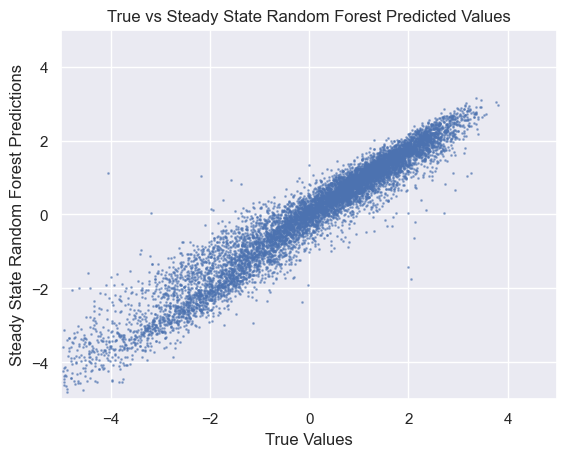

In [125]:
#Random forest on steady states
rf_model_steady = RandomForestRegressor(n_estimators=100, n_jobs=16, random_state=42)
rf_model_steady.fit(steadyStatesFeats, dataset.y)
y_steady = rf_model_steady.predict(steadyStatesFeats)
mse_steady = mean_squared_error(dataset.y, y_steady)
r2_steady = r2_score(dataset.y, y_steady)
mae_steady = mean_absolute_error(dataset.y, y_steady)
print(f'Steady State Random Forest Mean Squared Error: {mse_steady}')
print(f'Steady State Random Forest R^2 Score: {r2_steady}')
print(f'Steady State Random Forest Mean Absolute Error: {mae_steady}')
plt.scatter(dataset.y, y_steady, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Steady State Random Forest Predictions')
plt.title('True vs Steady State Random Forest Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [126]:
val_dataset = ZINC_Dataset.SMALL_VAL.load()
val_steadyStates = []
for graph in val_dataset:
    adj = to_dense_adj(graph.edge_index, batch=graph.batch, max_num_nodes=graph.num_nodes)
    adj = adj / adj.sum(dim=-1, keepdim=True)
    steadyState = torch.linalg.matrix_power(adj[0], 1000)[0]
    val_steadyStates.append(steadyState)
    val_steadyStatesFeats = torch.zeros((len(val_dataset), 21), dtype=torch.float)

for i in range(len(val_dataset)):
    steadyState = val_steadyStates[i]
    feats = val_dataset[i].x.squeeze()
    uniques, counts = torch.unique(feats, return_counts=True)
    for j, u in enumerate(uniques):
        val_steadyStatesFeats[i, u] = steadyState[feats == u].sum()
val_steadyStatesFeats.shape

torch.Size([1000, 21])

Validation Mean Squared Error: 4.201481342315674
Validation R^2 Score: -0.06670284271240234
Validation Mean Absolute Error: 1.5351814031600952


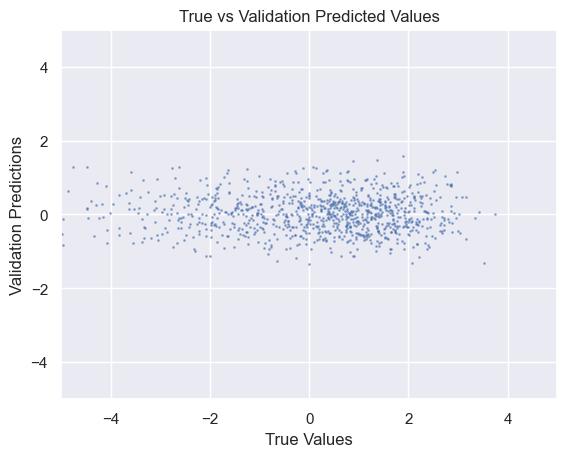

In [127]:
#Compute validation metrics
val_graphBON = torch.zeros((len(val_dataset), oneHot.shape[1]), dtype=torch.float)
for i in range(len(val_dataset)):
    val_graphBON[i] = oneHot[nodeCountCumSum[i]:nodeCountCumSum[i]+node_counts[i].int()].sum(dim=0)
    val_graphBON_target = torch.cat([val_graphBON, val_dataset.y.unsqueeze(1)], dim=1)

val_df = pd.DataFrame(val_graphBON_target.cpu().numpy(), columns=[f'Node_{i}' for i in range(val_graphBON.shape[1])] + ['Target'])
y_val = model.predict(val_graphBON)
val_mse = mean_squared_error(val_dataset.y, y_val)
val_r2 = r2_score(val_dataset.y, y_val)
val_mae = mean_absolute_error(val_dataset.y, y_val)
print(f'Validation Mean Squared Error: {val_mse}')
print(f'Validation R^2 Score: {val_r2}')
print(f'Validation Mean Absolute Error: {val_mae}')

plt.scatter(val_dataset.y, y_val, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Validation Predictions')
plt.title('True vs Validation Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()


# Random forest with degree features

In [128]:
from torch_geometric.transforms import OneHotDegree

one_hot_degree_transform = OneHotDegree(max_degree=4)

oneHotDegs = [one_hot_degree_transform(g).x[:, 2:].sum(dim=0) for g in dataset]
oneHotDegs = torch.stack(oneHotDegs)
oneHotDegs.shape

torch.Size([10000, 4])

In [129]:
oneHotDegs_target = torch.cat([oneHotDegs, dataset.y.unsqueeze(1)], dim=1)
oneHotDegs_target.shape

torch.Size([10000, 5])

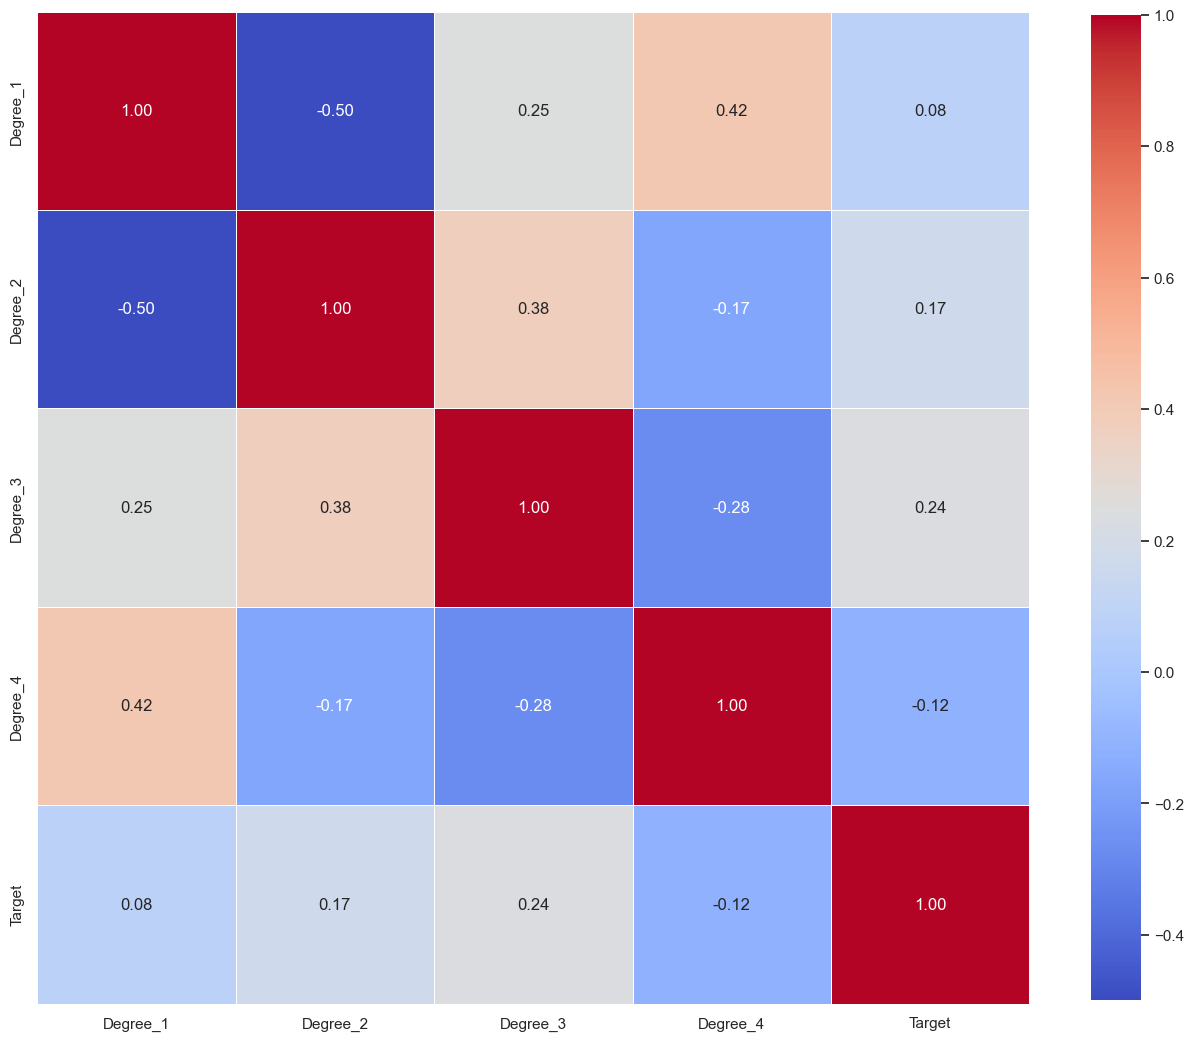

In [130]:
# print correlation matrix
corr_degs = pd.DataFrame(oneHotDegs_target.cpu().numpy(), columns=[f'Degree_{i+1}' for i in range(oneHotDegs.shape[1])] + ['Target']).corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_degs, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.show()

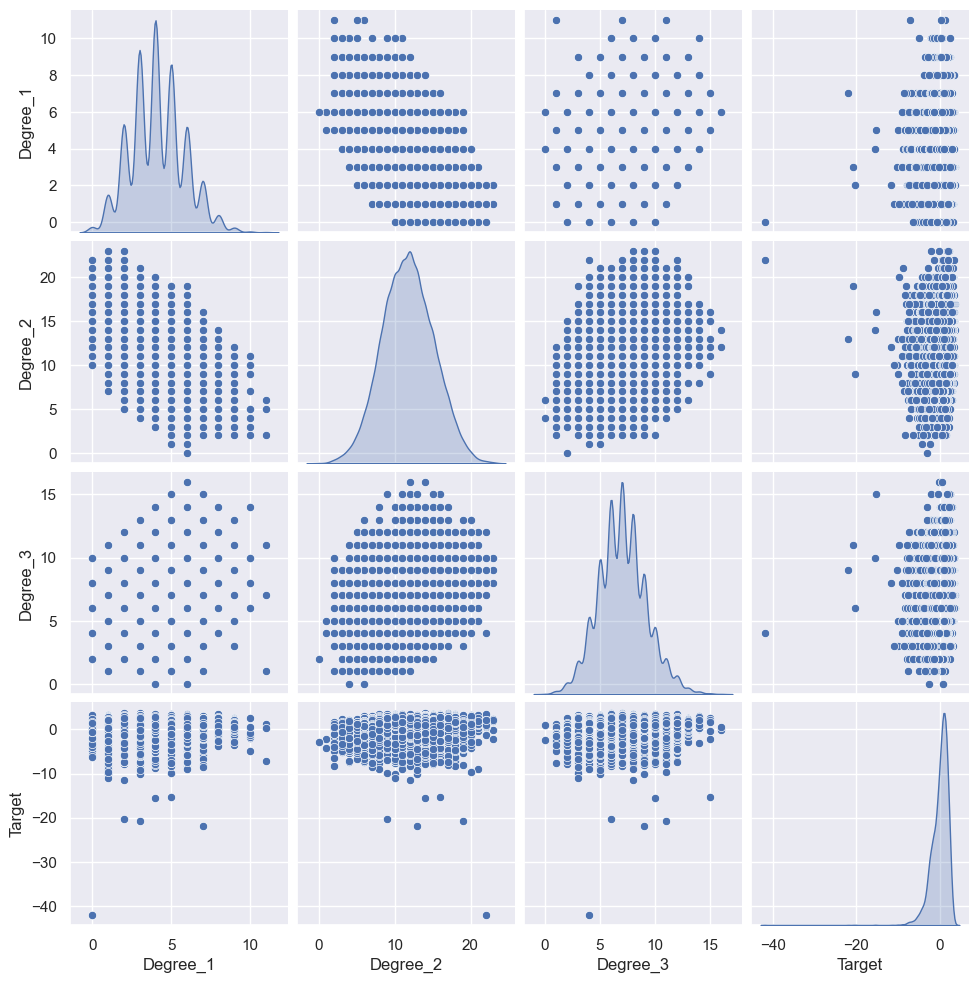

In [131]:
# Pairplot for one-hot degree features
df_degs = pd.DataFrame(oneHotDegs_target.cpu().numpy(), columns=[f'Degree_{i+1}' for i in range(oneHotDegs.shape[1])] + ['Target'])
sns.pairplot(df_degs[['Degree_1', 'Degree_2', 'Degree_3', 'Target']], diag_kind='kde', markers='o')
plt.show()

In [132]:
torch.mean(oneHotDegs.float(), dim=0)

tensor([ 4.1130, 11.7278,  7.0152,  0.3104])

In [133]:
# Random forest using degree features
rf_model_degs = RandomForestRegressor(n_estimators=100, n_jobs=8, random_state=42)
rf_model_degs.fit(oneHotDegs, dataset.y)
y_rf_degs = rf_model_degs.predict(oneHotDegs)
mse_rf_degs = mean_squared_error(dataset.y, y_rf_degs)
r2_rf_degs = r2_score(dataset.y, y_rf_degs)
mae_rf_degs = mean_absolute_error(dataset.y, y_rf_degs)
print(f'Random Forest with Degree Features Mean Squared Error: {mse_rf_degs}')
print(f'Random Forest with Degree Features R^2 Score: {r2_rf_degs}')
print(f'Random Forest with Degree Features Mean Absolute Error: {mae_rf_degs}')

Random Forest with Degree Features Mean Squared Error: 2.989240744563788
Random Forest with Degree Features R^2 Score: 0.26071049854041917
Random Forest with Degree Features Mean Absolute Error: 1.3010717502495106


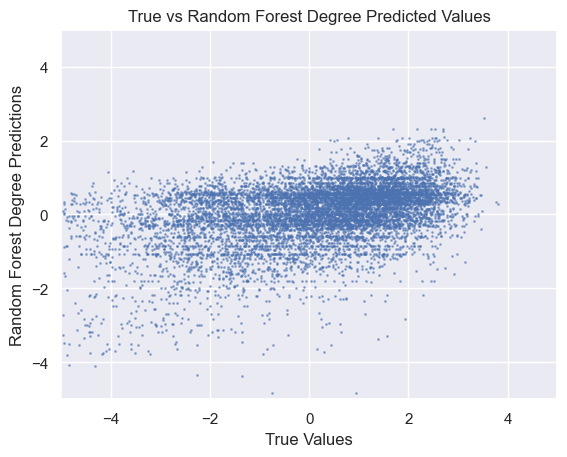

In [134]:
plt.scatter(dataset.y, y_rf_degs, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Random Forest Degree Predictions')
plt.title('True vs Random Forest Degree Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# Regression with BON + degs

In [135]:
Bon_degs = torch.cat([graphBON, oneHotDegs], dim=1)
Bon_degs_target = torch.cat([Bon_degs, dataset.y.unsqueeze(1)], dim=1)
df_bon_degs = pd.DataFrame(Bon_degs_target.cpu().numpy(),
                          columns=[f'Node_{i}' for i in range(graphBON.shape[1])] +
                                  [f'Degree_{i+1}' for i in range(oneHotDegs.shape[1])] + ['Target'])
df_bon_degs.head()

,Node_0,Node_1,Node_2,Node_3,Node_4,Node_5,Node_6,Node_7,Node_8,Node_9,...,Node_16,Node_17,Node_18,Node_19,Node_20,Degree_1,Degree_2,Degree_3,Degree_4,Target
0,21.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,14.0,9.0,1.0,0.835036
1,21.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,14.0,8.0,0.0,-2.193549
2,13.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,8.0,5.0,0.0,1.842230
3,21.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,13.0,10.0,0.0,-0.711533
4,12.0,1.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,10.0,5.0,1.0,0.246347


In [136]:
#Random forest using both Bon and degree features
rf_model_bon_degs = RandomForestRegressor(n_estimators=500, n_jobs=8, random_state=42)
rf_model_bon_degs.fit(Bon_degs, dataset.y)
y_rf_bon_degs = rf_model_bon_degs.predict(Bon_degs)
mse_rf_bon_degs = mean_squared_error(dataset.y, y_rf_bon_degs)
r2_rf_bon_degs = r2_score(dataset.y, y_rf_bon_degs)
mae_rf_bon_degs = mean_absolute_error(dataset.y, y_rf_bon_degs)
print(f'Random Forest with Bon and Degree Features Mean Squared Error: {mse_rf_bon_degs}')
print(f'Random Forest with Bon and Degree Features R^2 Score: {r2_rf_bon_degs}')
print(f'Random Forest with Bon and Degree Features Mean Absolute Error: {mae_rf_bon_degs}')


Random Forest with Bon and Degree Features Mean Squared Error: 0.6515705642663898
Random Forest with Bon and Degree Features R^2 Score: 0.8388556430263263
Random Forest with Bon and Degree Features Mean Absolute Error: 0.5870914525576982


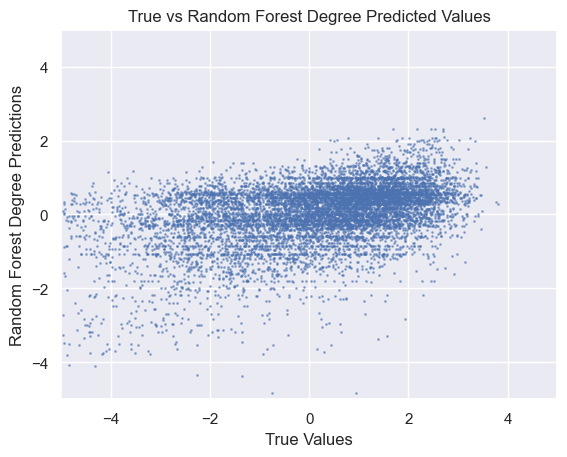

In [137]:
plt.scatter(dataset.y, y_rf_degs, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Random Forest Degree Predictions')
plt.title('True vs Random Forest Degree Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

# BON + degs NN using pytorch

In [138]:
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
input_size = Bon_degs.shape[1]
#Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Bon_degs_scaled = scaler.fit_transform(Bon_degs.cpu().numpy())
Bon_degs_scaled = torch.tensor(Bon_degs_scaled, dtype=torch.float32)

model_nn = SimpleNN(input_size=Bon_degs_scaled.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)

# Training the neural network
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    model_nn.train()
    optimizer.zero_grad()
    outputs = model_nn(Bon_degs_scaled.float())
    loss = criterion(outputs.squeeze(), dataset.y.float())
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        # Evaluating the neural network
model_nn.eval()
with torch.no_grad():
    y_nn = model_nn(Bon_degs_scaled.float()).squeeze()
    mse_nn = mean_squared_error(dataset.y, y_nn)
    r2_nn = r2_score(dataset.y, y_nn)
    mae_nn = mean_absolute_error(dataset.y, y_nn)
    print(f'Neural Network Mean Squared Error: {mse_nn}')
    print(f'Neural Network R^2 Score: {r2_nn}')
    print(f'Neural Network Mean Absolute Error: {mae_nn}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [10/1000], Loss: 3.9718
Epoch [20/1000], Loss: 3.8607
Epoch [30/1000], Loss: 3.7695
Epoch [40/1000], Loss: 3.7067
Epoch [50/1000], Loss: 3.6656
Epoch [60/1000], Loss: 3.6565
Epoch [70/1000], Loss: 3.6287
Epoch [80/1000], Loss: 3.6166
Epoch [90/1000], Loss: 3.6091
Epoch [100/1000], Loss: 3.5954
Epoch [110/1000], Loss: 3.5749
Epoch [120/1000], Loss: 3.5620
Epoch [130/1000], Loss: 3.5680
Epoch [140/1000], Loss: 3.5506
Epoch [150/1000], Loss: 3.5333
Epoch [160/1000], Loss: 3.5102
Epoch [170/1000], Loss: 3.5078
Epoch [180/1000], Loss: 3.4883
Epoch [190/1000], Loss: 3.4900
Epoch [200/1000], Loss: 3.4946
Epoch [210/1000], Loss: 3.4756
Epoch [220/1000], Loss: 3.4815
Epoch [230/1000], Loss: 3.4667
Epoch [240/1000], Loss: 3.4481
Epoch [250/1000], Loss: 3.4366
Epoch [260/1000], Loss: 3.4258
Epoch [270/1000], Loss: 3.4184
Epoch [280/1000], Loss: 3.4312
Epoch [290/1000], Loss: 3.4133
Epoch [300/1000], Loss: 3.4015
Epoch [310/1000], Loss: 3.4012
Epoch [320/1000], Loss: 3.4051
Epoch [330/1000],

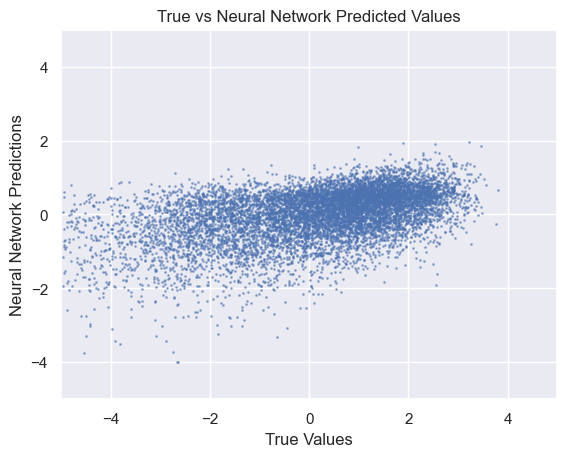

In [139]:
plt.scatter(dataset.y, y_nn, alpha=0.5, marker='o', s=1)
plt.xlabel('True Values')
plt.ylabel('Neural Network Predictions')
plt.title('True vs Neural Network Predicted Values')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()